## n-dimensional spectral decomposition

This uses `xarray` which is probably not something we want to depend on. But it's convenient for a demo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import xarray as xr

# 290 MB
data = np.load("/Users/matt/Dropbox/dev/notebooks/data/Penobscot_NumPy_.npy")
data = np.transpose(data, (1, 2, 0))

x, i, t = map(np.arange, data.shape)

data = xr.DataArray(data,
                    name='amplitude',
                    coords=[x, i, t],
                    dims=['xline', 'inline', 'time']
                   )

These axes are xline, inline, time.

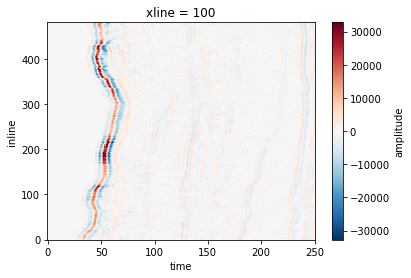

In [4]:
data[100].plot()

## Do spectral decomposition

We'll use scipy's `spectrogram` and put the result in an `xarray.DataArray()` for convenience.

We can compute the entire spectrogram, a 4D hypercube. Then we can take whatever slices we want from there.

In [5]:
import scipy.signal as ss

fs = 250  # Hz
window = 0.2  # seconds

nperseg = int(fs * window)  # samples in window
step = 1
noverlap = nperseg - step

# Entire cube uses too much memory.
data_ = data[100:130, 100:120]

f, t, Sxx = ss.spectrogram(data_,
                           fs=fs,
                           nperseg=nperseg,
                           noverlap=noverlap,
                           axis=-1,
                           scaling='spectrum',
                           mode='magnitude',
                          )

x = np.arange(data_.shape[0])
i = np.arange(data_.shape[1])

sd = xr.DataArray(np.sqrt(Sxx),
                  name='amplitude',
                  coords=[x, i, f, t],
                  dims=['xline', 'inline', 'freq', 'time']
                 )

In [6]:
sd.shape

(30, 20, 26, 202)

In [7]:
f

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125.])

The shape is xline, inline, frequency, time. There are only 26 frequency slices because of the length of the window and the 125 Hz Nyquist limit. The frequency samples are at intervals of 1 / `window` = 5 Hz. The first two are likely garbage (out of band) and so is anything above 0.8 * Nyquist = 100 Hz, typically (there's usually a hi-cut there in seismic acquisition, to reduce aliasing).

In [8]:
sd.coords

Coordinates:
  * xline    (xline) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * inline   (inline) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * freq     (freq) float64 0.0 5.0 10.0 15.0 20.0 ... 110.0 115.0 120.0 125.0
  * time     (time) float64 0.1 0.104 0.108 0.112 ... 0.892 0.896 0.9 0.904

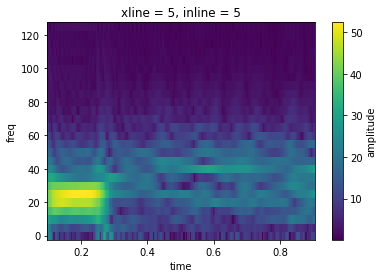

In [9]:
sd[5, 5].plot()

This is a time-frequency 'spectrogram' of 1 trace, but this is not usually what you want.

## RGB display

Make a 3-channel cube for 3 frequencies (and move freq 'channels' to last axis).

This is really nice becase `xarray` will do the interpolation for us. So even if the window was a weird length and the frequency samples were not whole numbers, `xarray` can do the interpolation for us. Cool!

In [14]:
rgb_ = sd.interp(freq=[10, 20, 40]).transpose(..., 'freq')

In [16]:
rgb_.shape

(30, 20, 202, 3)

Unfortunately, as far as I can tell, `xarray` won't plot a 3D array as RGB like `plt.imshow()` will, so we'll lose the coordinates.

In [17]:
rgb = (rgb_ - rgb_.min()) / (rgb_.max() - rgb_.min())

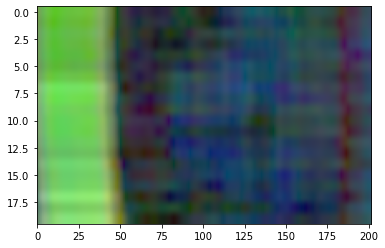

In [18]:
plt.imshow(rgb[5], aspect='auto')

There's no whitening or other tricks going on here, just the normalization. 

It's going to be a good idea to cut out the water column, and do the whitening step (per trace normalization, basically).

## Tuning cubes

Alternatively, we can get an entire cube at a particular frequency, again using `xarray`'s interpolation.

In [19]:
tc_40Hz = sd.interp(freq=40)
tc_40Hz.shape

(30, 20, 202)

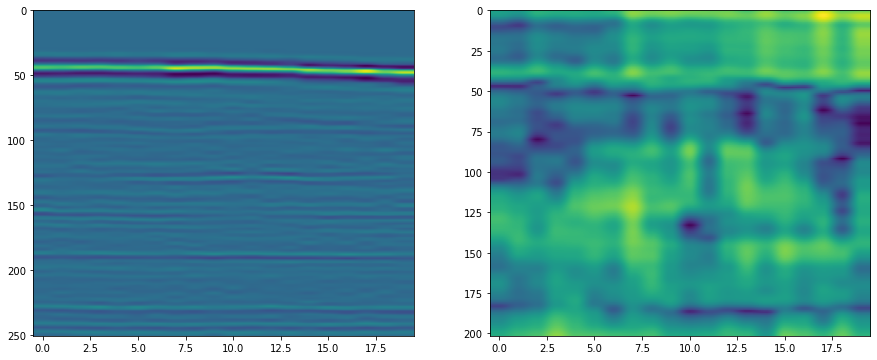

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6))

axs[0].imshow(data_[5].T, aspect='auto')
axs[1].imshow(tc_40Hz[5].T, aspect='auto')